In [2]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset

df = pd.read_csv('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv', header=None)


In [18]:
# classifier class

class Classifier(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            #nn.Sigmoid(),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),
            
            nn.Linear(200, 10),
            nn.Sigmoid()
            #nn.LeakyReLU(0.02)
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()
        #self.loss_function = nn.MSELoss()

        # create optimiser, using simple stochastic gradient descent
        #self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimiser = torch.optim.Adam(self.parameters())

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [19]:
class MnistDataset(Dataset):

  def __init__(self, csv_file):
    self.data_df = pd.read_csv(csv_file, header=None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, index):
    # 이미지 목표(레이블)
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    # 0~255의 이미지를 0~1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values)

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass

  pass


In [20]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

In [21]:
%%time
# 신경망 생성
C = Classifier()

# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epochs', i+1, "of", epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass
  pass


training epochs 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epochs 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epochs 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 12min 12s, sys: 7.93 s, total: 12min 20s
Wall time: 12min 19s


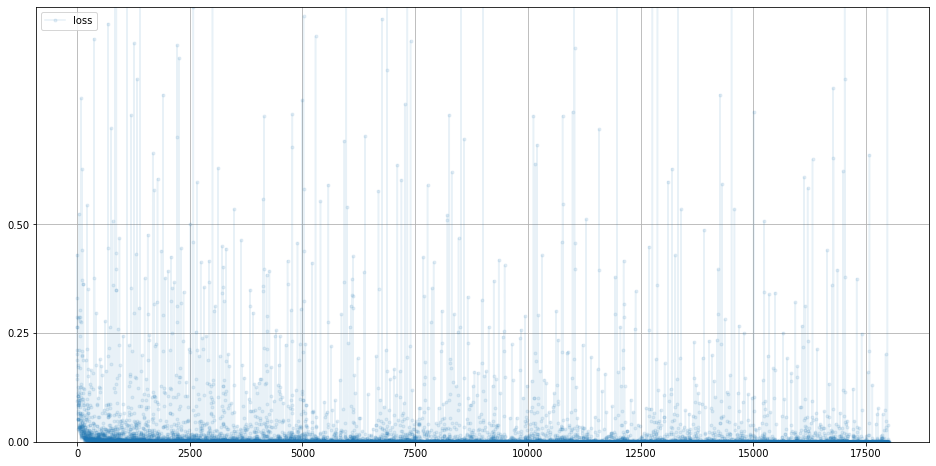

In [22]:
C.plot_progress()

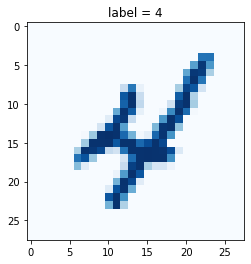

In [23]:
mnist_dataset.plot_image(9)

In [24]:
# load MNIST test data

mnist_test_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_test.csv')

In [25]:
# test trained neural network on training data

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

9725 10000 0.9725


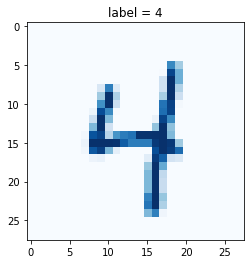

In [26]:
# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

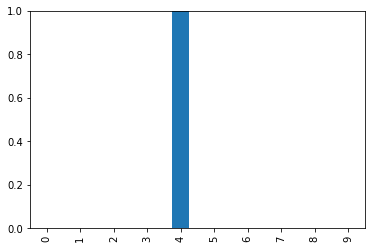

In [27]:
image_data = mnist_test_dataset[record][1]

# 훈련된 신경망으로부터 쿼리
output = C.forward(image_data)

# 텐서 출력
pd.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))